In [32]:
from google.cloud import bigquery
import db_dtypes

## 1.1 Importing Datasets

In [33]:
# Create a "Client" object
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='civil-dolphin-373610-189557442ab6.JSON'
client = bigquery.Client()

In [34]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)


In [35]:
# List all the tables in the "hacker_news" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there are four!)
for table in tables:  
    print(table.table_id)

comments
full
full_201510
stories


In [36]:
# Construct a reference to the "full" table
table_ref = dataset_ref.table("full")

# API request - fetch the table
table = client.get_table(table_ref)

In [37]:
df = client.list_rows(table, max_results = 1000).to_dataframe()

## 1.2 SELECT, FROM, and WHERE

In [38]:
dataset_ref = client.dataset("openaq", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# List all the tables in the "openaq" dataset
tables = list(client.list_tables(dataset))

# API request - fetch the table
table = client.get_table(table_ref)

In [39]:
query = """
        SELECT city
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        """

In [40]:
# API request - run the query, and return a pandas DataFrame
query_job = client.query(query)


us_cities = query_job.to_dataframe()

In [41]:
us_cities.value_counts().head()

city                                    
Phoenix-Mesa-Scottsdale                     39414
Los Angeles-Long Beach-Santa Ana            27479
Riverside-San Bernardino-Ontario            26887
New York-Northern New Jersey-Long Island    25417
San Francisco-Oakland-Fremont               22710
dtype: int64

## 1.3 GROUP BY, HAVING and COUNT

In [42]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)


In [43]:
query_popular = """
                SELECT parent, COUNT(id)
                FROM `bigquery-public-data.hacker_news.comments`
                GROUP BY parent
                HAVING COUNT(id) > 10
                """

In [44]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_popular, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
popular_comments = query_job.to_dataframe()

In [45]:
popular_comments.head()

,parent,f0_
0,225254,46
1,5403988,97
2,7244109,80
3,3748104,43
4,6995020,232


## 1.4 ORDER BY

In [46]:
# Construct a reference to the "nhtsa_traffic_fatalities" dataset
dataset_ref = client.dataset("nhtsa_traffic_fatalities", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "accident_2015" table
table_ref = dataset_ref.table("accident_2015")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "accident_2015" table
client.list_rows(table, max_results=5).to_dataframe()

,state_number,state_name,consecutive_number,number_of_vehicle_forms_submitted_all,number_of_motor_vehicles_in_transport_mvit,number_of_parked_working_vehicles,number_of_forms_submitted_for_persons_not_in_motor_vehicles,number_of_persons_not_in_motor_vehicles_in_transport_mvit,number_of_persons_in_motor_vehicles_in_transport_mvit,number_of_forms_submitted_for_persons_in_motor_vehicles,...,minute_of_ems_arrival_at_hospital,related_factors_crash_level_1,related_factors_crash_level_1_name,related_factors_crash_level_2,related_factors_crash_level_2_name,related_factors_crash_level_3,related_factors_crash_level_3_name,number_of_fatalities,number_of_drunk_drivers,timestamp_of_crash
0,37,North Carolina,370709,7,2,5,5,5,3,3,...,3,0,None,0,None,0,None,2,0,2015-07-17 06:19:00+00:00
1,47,Tennessee,470852,2,2,0,3,3,2,2,...,99,14,Motor Vehicle (In Transport 1983-2004) Struck ...,0,None,0,None,1,0,2015-12-13 17:52:00+00:00
2,28,Mississippi,280390,1,1,0,3,3,1,1,...,32,0,None,0,None,0,None,1,0,2015-09-12 09:28:00+00:00
3,1,Alabama,10476,1,1,0,3,3,1,1,...,99,0,None,0,None,0,None,1,0,2015-08-29 08:15:00+00:00
4,21,Kentucky,210534,2,2,0,6,6,2,2,...,41,14,Motor Vehicle (In Transport 1983-2004) Struck ...,0,None,0,None,1,0,2015-10-16 17:20:00+00:00


In [47]:
# Query to find out the number of accidents for each day of the week
query = """
        SELECT COUNT(consecutive_number) AS num_accidents, 
               EXTRACT(DAYOFWEEK FROM timestamp_of_crash) AS day_of_week
        FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
        GROUP BY day_of_week
        ORDER BY num_accidents DESC
        """

In [48]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**9)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
accidents_by_day = query_job.to_dataframe()

# Print the DataFrame
accidents_by_day

,num_accidents,day_of_week
0,5659,7
1,5298,1
2,4916,6
3,4460,5
4,4182,4
5,4038,2
6,3985,3


## 1.5 AS and WITH

In [49]:
# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
client.list_rows(table, max_results=5).to_dataframe()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


In [50]:
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()


,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


<AxesSubplot:xlabel='trans_date'>

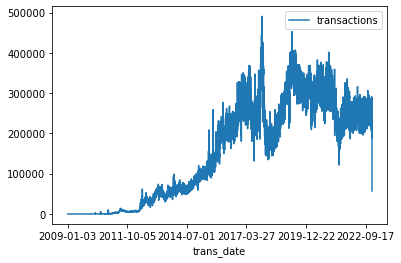

In [51]:
transactions_by_date.set_index('trans_date').plot()

## 1.6 JOINS

In [52]:
# Construct a reference to the "github_repos" dataset
dataset_ref = client.dataset("github_repos", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "licenses" table
licenses_ref = dataset_ref.table("licenses")

# API request - fetch the table
licenses_table = client.get_table(licenses_ref)

# Preview the first five lines of the "licenses" table
client.list_rows(licenses_table, max_results=5).to_dataframe()

,repo_name,license
0,autarch/Dist-Zilla-Plugin-Test-TidyAll,artistic-2.0
1,thundergnat/Prime-Factor,artistic-2.0
2,kusha-b-k/Turabian_Engin_Fan,artistic-2.0
3,onlinepremiumoutlet/onlinepremiumoutlet.github.io,artistic-2.0
4,huangyuanlove/LiaoBa_Service,artistic-2.0


In [53]:
# Construct a reference to the "sample_files" table
files_ref = dataset_ref.table("sample_files")

# API request - fetch the table
files_table = client.get_table(files_ref)

# Preview the first five lines of the "sample_files" table
client.list_rows(files_table, max_results=5).to_dataframe()


,repo_name,ref,path,mode,id,symlink_target
0,EOL/eol,refs/heads/master,generate/vendor/railties,40960,0338c33fb3fda57db9e812ac7de969317cad4959,/usr/share/rails-ruby1.8/railties
1,np/ling,refs/heads/master,tests/success/merger_seq_inferred.t/merger_seq...,40960,dd4bb3d5ecabe5044d3fa5a36e0a9bf7ca878209,../../../fixtures/all/merger_seq_inferred.ll
2,np/ling,refs/heads/master,fixtures/sequence/lettype.ll,40960,8fdf536def2633116d65b92b3b9257bcf06e3e45,../all/lettype.ll
3,np/ling,refs/heads/master,fixtures/failure/wrong_order_seq3.ll,40960,c2509ae1196c4bb79d7e60a3d679488ca4a753e9,../all/wrong_order_seq3.ll
4,np/ling,refs/heads/master,issues/sequence/keep.t,40960,5721de3488fb32745dfc11ec482e5dd0331fecaf,../keep.t


In [54]:
# Query to determine the number of files per license, sorted by number of files
query = """
        SELECT L.license, COUNT(1) AS number_of_files
        FROM `bigquery-public-data.github_repos.sample_files` AS sf
        INNER JOIN `bigquery-public-data.github_repos.licenses` AS L 
            ON sf.repo_name = L.repo_name
        GROUP BY L.license
        ORDER BY number_of_files DESC
        """

# Set up the query (cancel the query if it would use too much of 

# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
file_count_by_license = query_job.to_dataframe()

In [55]:
# Print the DataFrame
file_count_by_license

,license,number_of_files
0,mit,20560894
1,gpl-2.0,16608922
2,apache-2.0,7201141
3,gpl-3.0,5107676
4,bsd-3-clause,3465437
5,agpl-3.0,1372100
6,lgpl-2.1,799664
7,bsd-2-clause,692357
8,lgpl-3.0,582277
9,mpl-2.0,457000
